In [1]:
import os
import re
import sys
import pdb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
sys.path.append("../src")

import main

In [130]:
from skimage import color, transform, restoration, io, feature, img_as_ubyte
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score 

from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Convolution2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [136]:
raw_image_path = '../data/raw/gray_8'
ip = main.ImagePipeline(raw_image_path)
ip.read()
# for i in [64,32,16,8]:
for i in [4]:
    ip.resize(shape = (i,i,3))
    ip.grayscale()
    savename = 'gray_' + str(i)
    ip.save(savename)

/usr/local/lib/python3.5/dist-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


'/tf/gal/repos/capstones/car-image-classification/notebooks/chevrolet_trailblazer_2005' does not exist

In [ ]:
# os.rmdir('../data/interim/image_data/gray_128/')

In [ ]:
# os.rmdir('../data/interim/image_data/gray_128/chevrolet_trailblazer_2005')

In [ ]:
# df = pd.read_pickle('../data/interim/numerical_data/scores_gray_x.pkl')

In [140]:
t_sub = 'gray_4'
i_sub = '../data/interim/image_data/binary/forest/' + str(t_sub)

In [141]:
ip = main.ImagePipeline(i_sub)

In [142]:
ip.read()

In [143]:
features, target = ip.vectorize()
print('splitting train/test \n')
X_train, X_test, y_train, y_test = train_test_split(features, target,
                                                    test_size=0.2,
                                                    random_state=42)
rf_accuracy_lst = []
rf_precision_lst = []
rf_recall_lst = []
rf_num_trees_list = list(np.arange(100,1000,20))
rf_num_trees_list.extend(list(np.arange(1000,5000,200)))
# rf_num_trees_list = [10000]

for num_trees in rf_num_trees_list:
    print('RF',num_trees,'Classifying...', i_sub,'\n')
    rf = RandomForestClassifier(bootstrap=True,
                                ccp_alpha=0.0,
                                class_weight='balanced',  # default None
                                criterion='gini',
                                max_depth=None, #default None
                                max_features='auto',  # None = +-8% of % long rt
                                max_leaf_nodes=None,
                                max_samples=None,
                                min_impurity_decrease=0.0,
                                min_impurity_split=None,
                                min_samples_leaf=1,
                                min_samples_split=2,
                                min_weight_fraction_leaf=0.0,
                                n_estimators=num_trees,  # two class=100=0.70, 1000=0.75,10k=0.74
                                n_jobs=-2,  # use all CPUs but 1
                                oob_score=True, # Use out-of-bag samples
                                random_state=1,
                                verbose=0,
                                warm_start=False
                                )
    print('RF Fitting...\n')
    rf.fit(X_train, y_train)
    print('Predicting...\n')
    rf_preds = rf.predict(X_test)
    print('Calculating Accuracy...\n')
    rf_accuracy_lst.append(accuracy_score(y_test, rf_preds))
    rf_precision_lst.append(precision_score(y_test, rf_preds, average='weighted'))
    rf_recall_lst.append(recall_score(y_test, rf_preds, average='weighted'))

splitting train/test 

RF 100 Classifying... ../data/interim/image_data/binary/forest/gray_4 

RF Fitting...

Predicting...

Calculating Accuracy...

RF 120 Classifying... ../data/interim/image_data/binary/forest/gray_4 

RF Fitting...

Predicting...

Calculating Accuracy...

RF 140 Classifying... ../data/interim/image_data/binary/forest/gray_4 

RF Fitting...

Predicting...

Calculating Accuracy...

RF 160 Classifying... ../data/interim/image_data/binary/forest/gray_4 

RF Fitting...

Predicting...

Calculating Accuracy...

RF 180 Classifying... ../data/interim/image_data/binary/forest/gray_4 

RF Fitting...

Predicting...

Calculating Accuracy...

RF 200 Classifying... ../data/interim/image_data/binary/forest/gray_4 

RF Fitting...

Predicting...

Calculating Accuracy...

RF 220 Classifying... ../data/interim/image_data/binary/forest/gray_4 

RF Fitting...

Predicting...

Calculating Accuracy...

RF 240 Classifying... ../data/interim/image_data/binary/forest/gray_4 

RF Fitting...

P

Predicting...

Calculating Accuracy...



In [144]:
len(rf_accuracy_lst)

65

In [145]:
len(rf_precision_lst)

65

In [146]:
len(rf_recall_lst)

65

In [147]:
len(rf_num_trees_list)

65

In [148]:
df = pd.read_pickle('../data/interim/numerical_data/scores_gray_x_add_2.pkl')
df.shape

(65, 16)

In [149]:
t_sub

'gray_4'

In [150]:
df = pd.read_pickle('../data/interim/numerical_data/scores_gray_x_add_2.pkl')
col_name = 'accuracy_'
col_name += t_sub
df[col_name] = rf_accuracy_lst

col_name = 'precision_'  
col_name += t_sub
df[col_name] =  rf_precision_lst

col_name = 'recall_'
col_name += t_sub
df[col_name] = rf_recall_lst

df['num_trees'] = rf_num_trees_list
df.to_csv('../data/interim/numerical_data/scores_gray_x_add_4.csv')
df.to_pickle('../data/interim/numerical_data/scores_gray_x_add_4.pkl')

In [151]:
df.head()

,accuracy_gray_16,precision_gray_16,recall_gray_16,accuracy_gray_32,precision_gray_32,recall_gray_32,accuracy_gray_64,precision_gray_64,recall_gray_64,accuracy_gray_8,precision_gray_8,recall_gray_8,num_trees,accuracy_gray_2,precision_gray_2,recall_gray_2,accuracy_gray_4,precision_gray_4,recall_gray_4
0,0.748387,0.726316,0.841463,0.703226,0.711538,0.822222,0.722581,0.719626,0.855556,0.766667,0.768372,0.766667,100,0.550000,0.549554,0.550000,0.658333,0.663630,0.658333
1,0.696774,0.680412,0.804878,0.716129,0.712963,0.855556,0.729032,0.714286,0.888889,0.775000,0.777541,0.775000,120,0.533333,0.532850,0.533333,0.658333,0.659179,0.658333
2,0.709677,0.690722,0.817073,0.741935,0.735849,0.866667,0.722581,0.711712,0.877778,0.775000,0.777541,0.775000,140,0.566667,0.566257,0.566667,0.666667,0.667232,0.666667
3,0.709677,0.686869,0.829268,0.729032,0.718182,0.877778,0.722581,0.711712,0.877778,0.791667,0.791863,0.791667,160,0.566667,0.565993,0.566667,0.658333,0.659179,0.658333
4,0.741935,0.718750,0.841463,0.729032,0.718182,0.877778,0.729032,0.718182,0.877778,0.758333,0.759382,0.758333,180,0.550000,0.549554,0.550000,0.683333,0.683185,0.683333


In [ ]:
fig, ax = plt.subplots(figsize=(8,4), dpi=200)
ax.plot(rf_num_trees_list,rf_recall_lst)

In [176]:
y_predict = rf.predict(X_test)
print(confusion_matrix(y_test, y_predict))

[[49 13]
 [14 44]]


In [152]:
dfp = pd.read_pickle('../data/interim/numerical_data/scores_gray_x_add_4.pkl')

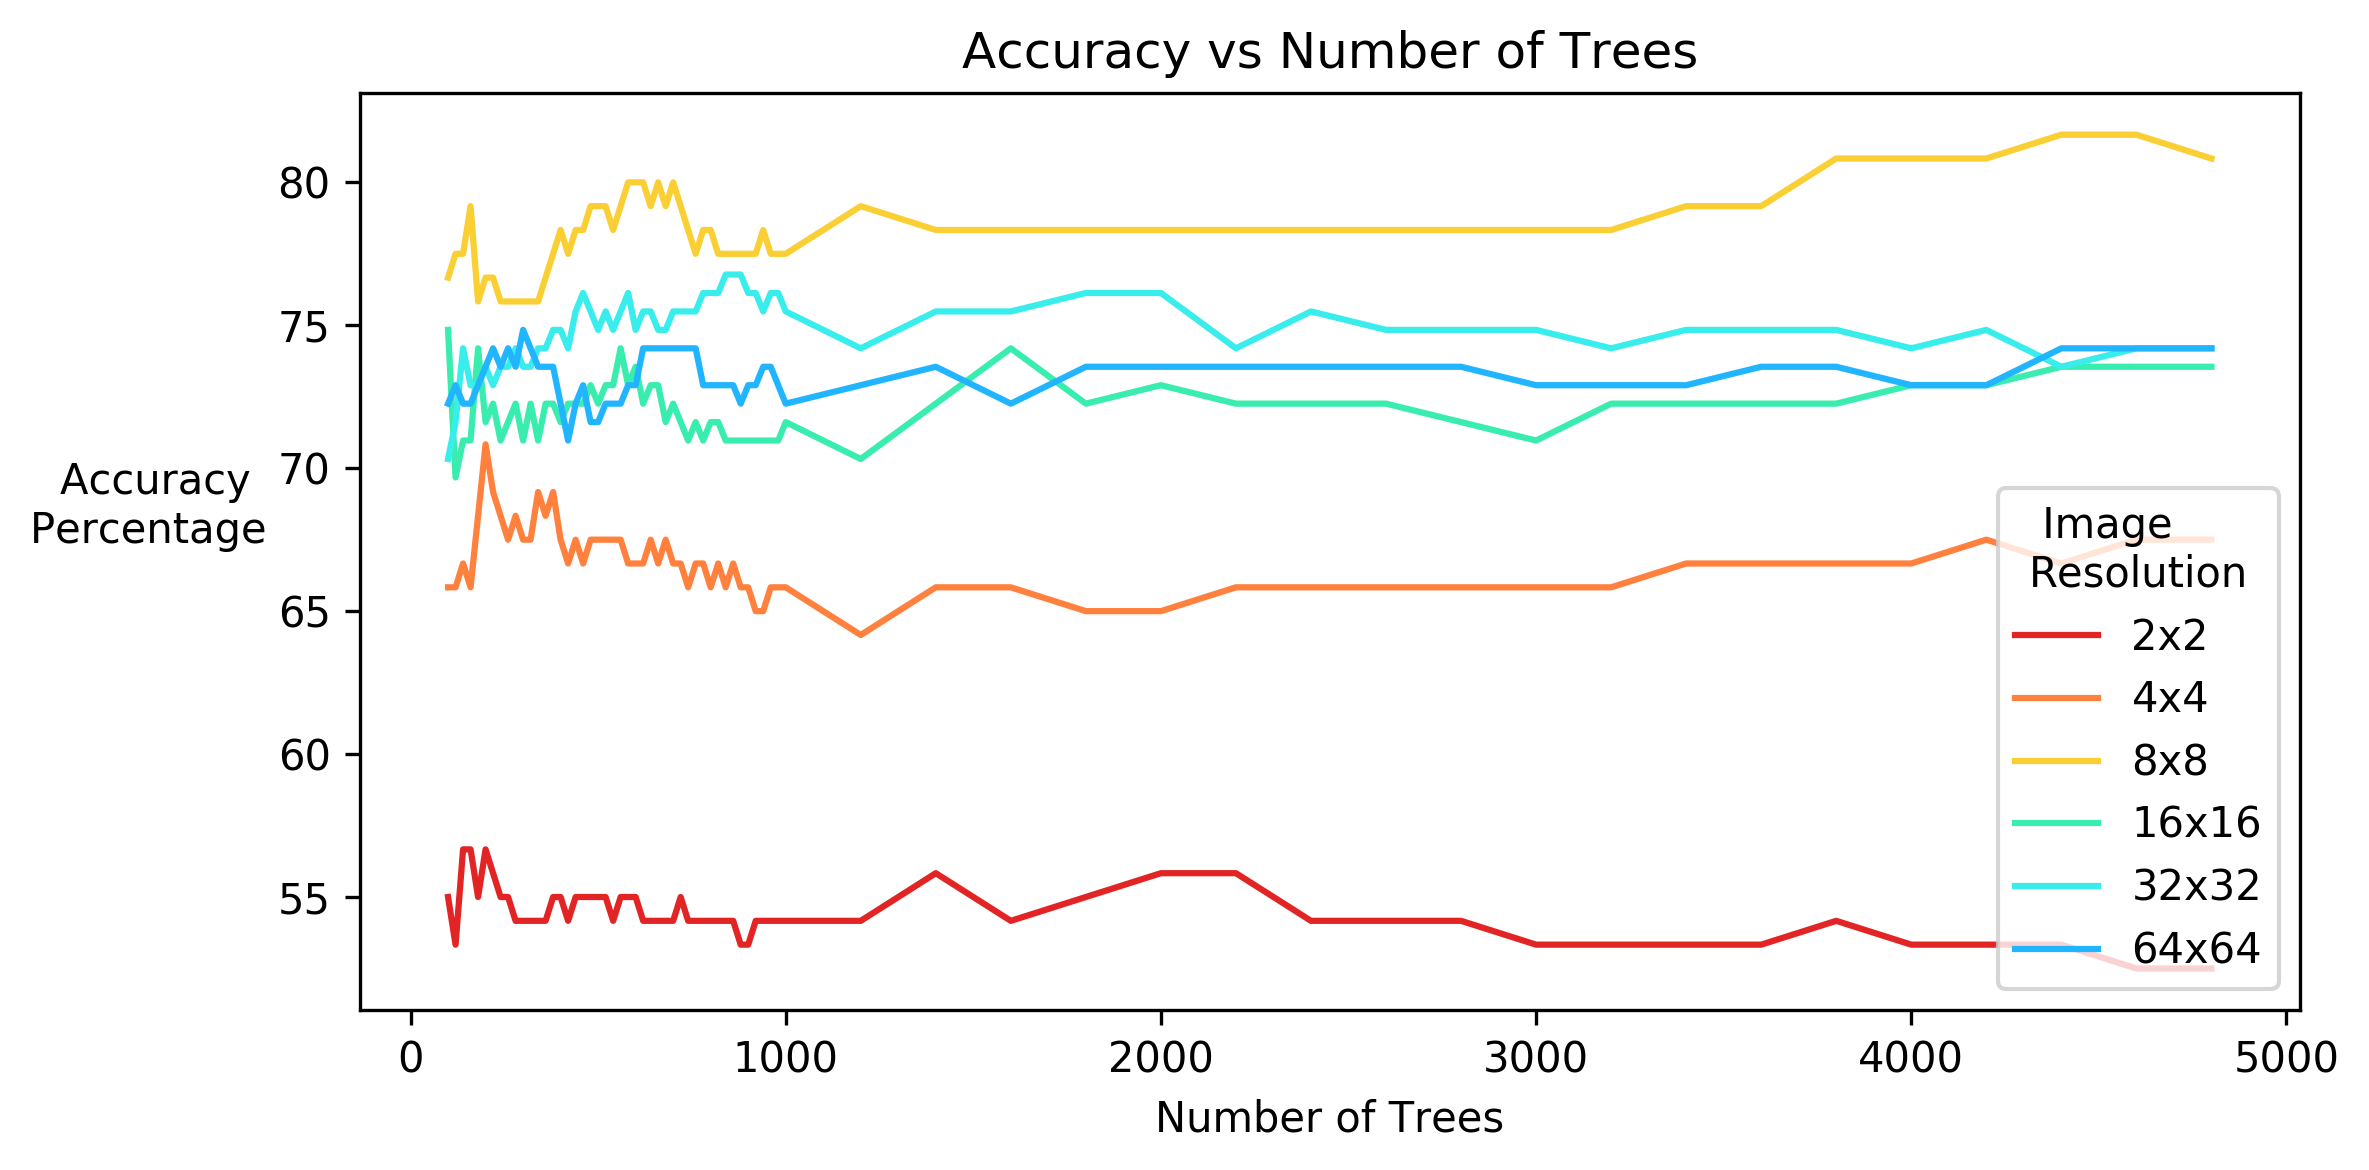

In [164]:
fig = plt.figure(figsize=(8,4), dpi=300)
ax = fig.add_subplot(1, 1, 1)


ax.plot(rf_num_trees_list, 
        (100*dfp.accuracy_gray_2), 
        label = '2x2',
        color = '#e32424'
        )
ax.plot(rf_num_trees_list, 
        (100*dfp.accuracy_gray_4), 
        label = '4x4',
        color = '#ff813d'
        )
ax.plot(rf_num_trees_list, 
        (100*dfp.accuracy_gray_8), 
        label = '8x8',
        color = '#facf34'
        )
ax.plot(rf_num_trees_list, 
        (100*dfp.accuracy_gray_16), 
        label = '16x16',
        color = '#39edae'
        )
ax.plot(rf_num_trees_list, 
        (100*dfp.accuracy_gray_32), 
        label = '32x32',
        color = '#39eded'
        )
ax.plot(rf_num_trees_list, 
        (100*dfp.accuracy_gray_64), 
        label = '64x64',
        color = '#21b5ff'
        )

hline_height = 100 * dfp[['accuracy_gray_8', 
                        'accuracy_gray_16', 
                        'accuracy_gray_32', 
                        'accuracy_gray_64']].max().max()
# plt.axhline(y=hline_height, linewidth=1,linestyle='--', color='k', alpha=0.3)
# plt.axvline(x=860, linewidth=3,linestyle='--', color='k', alpha=0.15)

plt.title('Accuracy vs Number of Trees')
plt.xlabel('Number of Trees')
plt.ylabel('Accuracy                \nPercentage                 ', rotation='horizontal')
plt.legend(title=' Image\nResolution')
plt.tight_layout()
plt.savefig('../reports/figures/rf-num-tree-10k-acc-4.png')

In [175]:
hline_height = 100 * dfp[['accuracy_gray_8', 
                        'accuracy_gray_16', 
                        'accuracy_gray_32', 
                        'accuracy_gray_64']].max().max()
hline_height

81.66666666666667

In [171]:
t_sub = 'gray_8'
i_sub = '../data/interim/image_data/binary/forest/' + str(t_sub)
ip = main.ImagePipeline(i_sub)
ip.read()

In [172]:
features, target = ip.vectorize()
X_train, X_test, y_train, y_test = train_test_split(features, target,
                                                    test_size=0.2,
                                                    random_state=42)
rf = RandomForestClassifier(bootstrap=True,
                            ccp_alpha=0.0,
                            class_weight='balanced',  # default None
                            criterion='gini',
                            max_depth=None, #default None
                            max_features='auto',  # None = +-8% of % long rt
                            max_leaf_nodes=None,
                            max_samples=None,
                            min_impurity_decrease=0.0,
                            min_impurity_split=None,
                            min_samples_leaf=1,
                            min_samples_split=2,
                            min_weight_fraction_leaf=0.0,
                            n_estimators=860,  # two class=100=0.70, 1000=0.75,10k=0.74
                            n_jobs=-2,  # use all CPUs but 1
                            oob_score=True, # Use out-of-bag samples
                            random_state=1,
                            verbose=0,
                            warm_start=False
                            )
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)

Feature ranking:
1. feature 11 (0.026837)
2. feature 19 (0.023927)
3. feature 37 (0.023926)
4. feature 38 (0.023806)
5. feature 20 (0.023308)
6. feature 12 (0.023129)
7. feature 34 (0.022217)
8. feature 61 (0.021000)
9. feature 53 (0.020754)
10. feature 44 (0.020296)
11. feature 60 (0.019995)
12. feature 35 (0.018637)
13. feature 18 (0.018410)
14. feature 59 (0.018102)
15. feature 10 (0.017689)
16. feature 45 (0.017370)
17. feature 36 (0.017299)
18. feature 58 (0.017233)
19. feature 29 (0.017082)
20. feature 43 (0.016914)
21. feature 52 (0.016779)
22. feature 51 (0.016733)
23. feature 30 (0.016253)
24. feature 62 (0.016017)
25. feature 21 (0.015919)
26. feature 33 (0.015561)
27. feature 13 (0.015550)
28. feature 54 (0.015543)
29. feature 50 (0.015338)
30. feature 6 (0.015174)


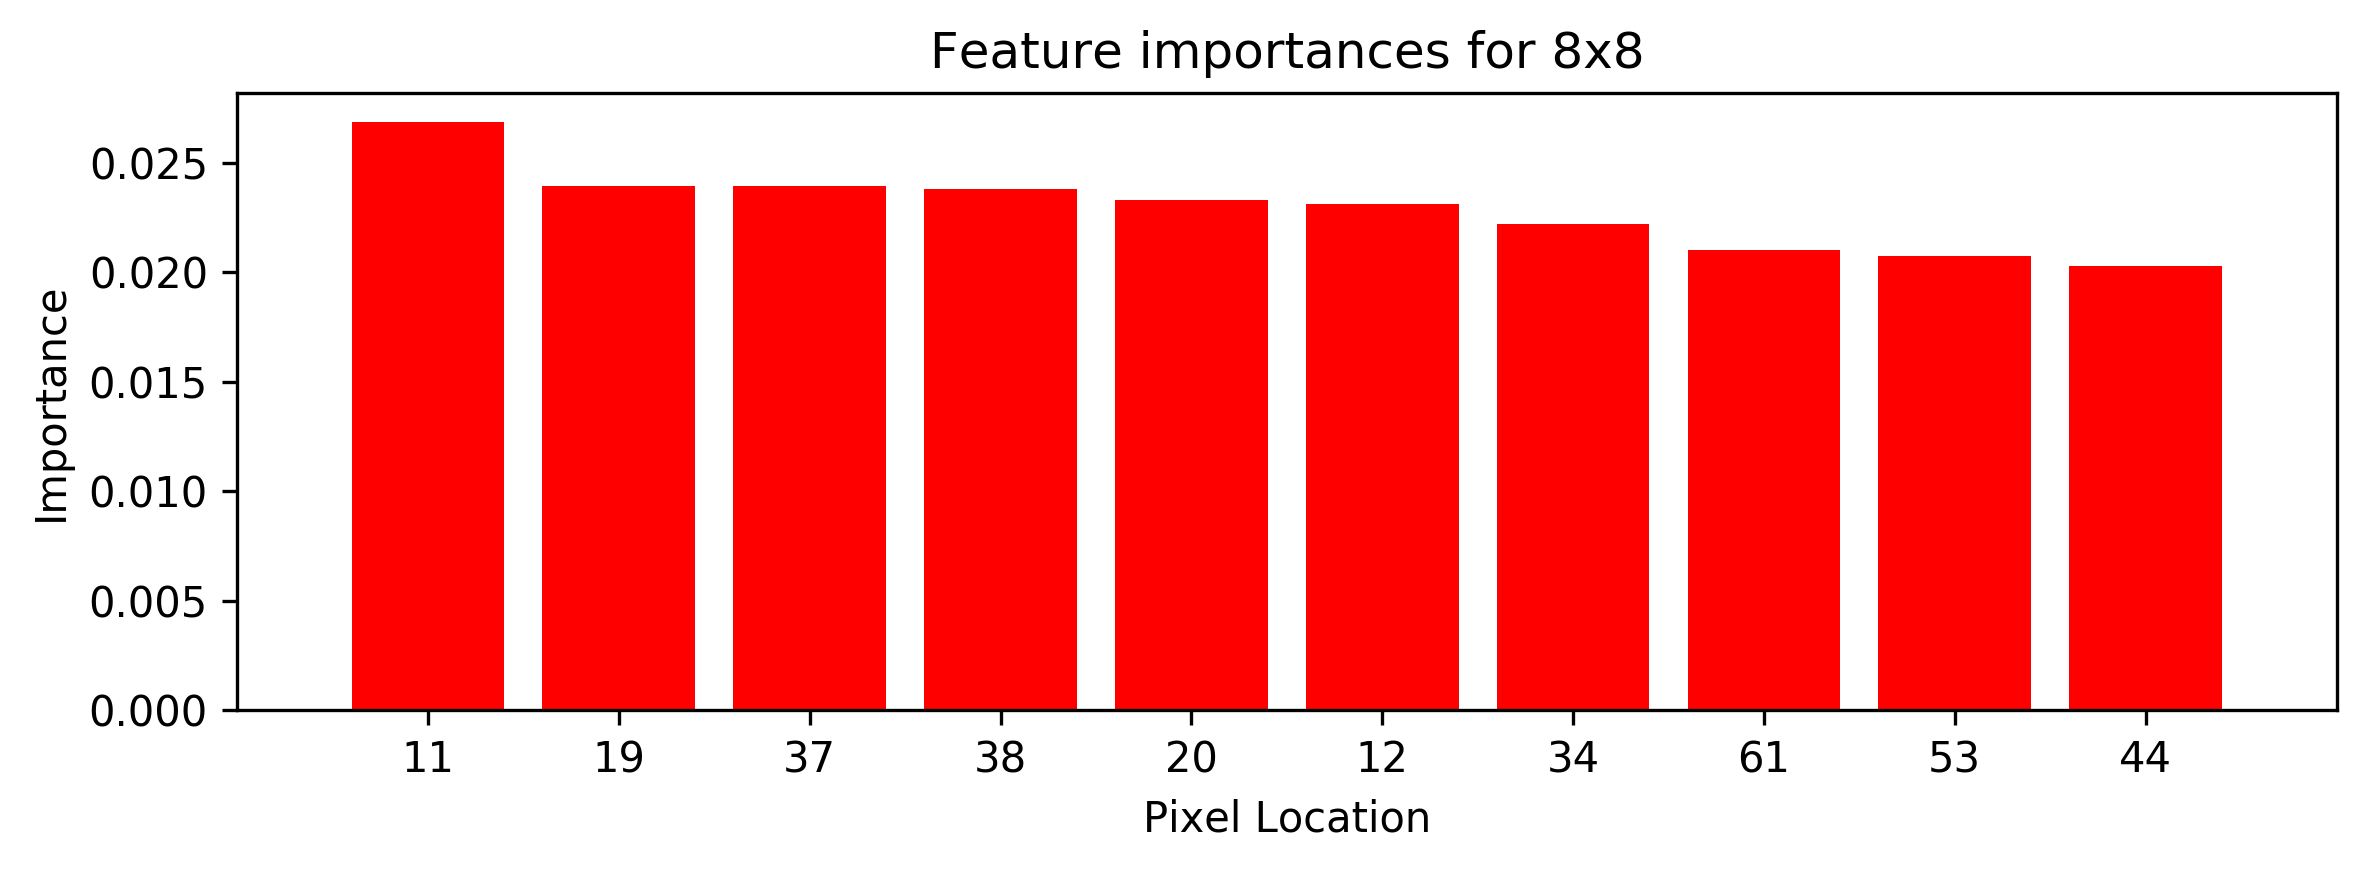

In [173]:
forest = ExtraTreesClassifier(n_estimators=860,
                              random_state=42)

forest.fit(X_train, y_train)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]


# Print the feature ranking
print("Feature ranking:")

for f in range(30):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the impurity-based feature importances of the forest
plt.figure(figsize=(8,3),dpi=300)
plt.title("Feature importances for 8x8")
plt.bar(range(10), importances[indices][:10],
        color="r", align="center")
plt.xticks(range(10), indices[:10])
plt.ylabel('Importance')
plt.xlabel('Pixel Location')
plt.xlim([-1, 10])
plt.tight_layout()
plt.show()

In [ ]:
# dimensions of our images.
img_width, img_height = 128, 128
num_classes = 5

train_data_dir = '../data/interim/image_data/gray_'+ str(img_width)+'/train'
validation_data_dir = '../data/interim/image_data/gray_'+ str(img_width)+'/val'
nb_train_samples = 1200
nb_validation_samples = 300
num_epochs = 20
batch_size = 16

In [53]:
train_datagen = ImageDataGenerator(
                        rescale=1./255,
                        shear_range=0.2,
                        zoom_range=0.2,
                        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

val_datagen = ImageDataGenerator(rescale=1./255.,validation_split=0.25)

In [7]:
base_model = keras.applications.Xception(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(img_width, img_height, 3),
    include_top=False)  # Do not include the ImageNet classifier at the top (chop off head)

In [8]:
base_model.trainable = False

In [12]:
inputs = keras.Input(shape=(img_width, img_height, 3))
# We make sure that the base_model is running in inference mode,
# by passing `training=False`.
x = base_model(inputs, training=False)
# Convert features of shape `base_model.output_shape[1:]` to vectors
x = keras.layers.GlobalAveragePooling2D()(x)
# A Dense classifier with a 5 units (5 classes)
outputs = keras.layers.Dense(num_classes)(x)
model = keras.Model(inputs, outputs)

In [29]:
train_data_dir

'../data/interim/image_data/gray_128/train'

In [54]:
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    subset="training",
    batch_size=batch_size,
    class_mode="categorical"
    )

validation_generator = val_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    subset="validation",
    batch_size=batch_size,
    class_mode="categorical"
    )

test_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode=None #try None here
    )

Found 1200 images belonging to 5 classes.
Found 300 images belonging to 5 classes.
Found 300 images belonging to 5 classes.


In [56]:
base_model.trainable = True


model.compile(optimizer=keras.optimizers.Adam(1e-4),  # Very low learning rate
              loss=keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=[keras.metrics.CategoricalAccuracy()])

# Train end-to-end. Be careful to stop before you overfit!
model.fit(train_generator, epochs=num_epochs, validation_data=validation_generator)

Epoch 1/20
75/75 [==============================] - 192s 3s/step - loss: 0.7902 - categorical_accuracy: 0.6850 - val_loss: 0.3749 - val_categorical_accuracy: 0.8567
Epoch 2/20
75/75 [==============================] - 175s 2s/step - loss: 0.3136 - categorical_accuracy: 0.8858 - val_loss: 0.3167 - val_categorical_accuracy: 0.8800
Epoch 3/20
75/75 [==============================] - 171s 2s/step - loss: 0.1585 - categorical_accuracy: 0.9483 - val_loss: 0.1212 - val_categorical_accuracy: 0.9600
Epoch 4/20
75/75 [==============================] - 176s 2s/step - loss: 0.0756 - categorical_accuracy: 0.9725 - val_loss: 0.1221 - val_categorical_accuracy: 0.9500
Epoch 5/20
75/75 [==============================] - 188s 3s/step - loss: 0.1098 - categorical_accuracy: 0.9633 - val_loss: 0.0246 - val_categorical_accuracy: 0.9933
Epoch 6/20
75/75 [==============================] - 198s 3s/step - loss: 0.0334 - categorical_accuracy: 0.9883 - val_loss: 0.0382 - val_categorical_accuracy: 0.9900
Epoch 7/20

In [43]:
# Learning rate of 1e-4 43% early epochs
# Learning rate of 1e-5 41% early epochs
# Learning rate of 1e-6 42% early epochs

model.compile(optimizer=keras.optimizers.Adam(1e-4),
              loss=keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=[keras.metrics.CategoricalAccuracy()])
model.fit(train_generator, epochs=num_epochs, validation_data=validation_generator)

Epoch 1/20
57/75 [=====================>........] - ETA: 40s - loss: 1.8110 - categorical_accuracy: 0.2039

KeyboardInterrupt: 

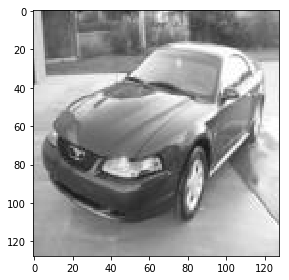

In [58]:
img1_dir = '../data/interim/image_data/gray_128/ford_mustang_2003/00V0V_cIug9rFQXkY_600x450.jpg'
io.imshow(img1_dir)

In [60]:
img1 = io.imread(img1_dir)
img1

Array([[212, 211, 213, ..., 160, 160, 157],
       [212, 212, 216, ..., 161, 166, 166],
       [210, 210, 218, ..., 153, 160, 161],
       ...,
       [156, 156, 157, ..., 218, 215, 212],
       [154, 154, 155, ..., 216, 214, 211],
       [152, 152, 153, ..., 217, 215, 214]], dtype=uint8)

In [ ]:
model.predict(img1)

In [ ]:
# to make train / val(test) folders
split_folders.ratio('../data/interim/image_data/gray_64', output="../data/interim/image_data/gray_64", seed=42, ratio=(.8, .2))

In [ ]:
# t_sub_dirs = ['gray_16', 'gray_32', 'gray_64']
# ip2 = main.ImagePipeline(os.path.join('../data/interim/image_data',t_sub_dirs[0]))

In [ ]:
features, target = ip.vectorize()
X_train, 
X_test, 
y_train, 
y_test = train_test_split(features, target,
                            test_size=0.2,
                            random_state=42)

In [ ]:
# dimensions of our images.
img_width, img_height = 128, 128

train_data_dir = '../data/interim/image_data/gray_128/train'
validation_data_dir = '../data/interim/image_data/gray_128/val'
nb_train_samples = 1200
nb_validation_samples = 300
epochs = 50
batch_size = 16

if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

model = Sequential()
model.add(Convolution2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(5))
model.add(Activation('sigmoid'))

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
    rescale=1.,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1.)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size)

model.save_weights('x_try_128.h5')

In [ ]:

Create_Model(df=df_eval_trans, transformed_sub_dirs = ['gray_16', 'gray_32', 'gray_64'], s=(64,64,3))


print('plotting...\n\n')
plot_accuracies(df_eval_trans)
plot_precisions(df_eval_trans)
plot_recalls(df_eval_trans)